In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
from torch import nn
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from utils.genre_classification import evaluate, executor, feature_preparator

In [2]:
def permute_channels(x: np.ndarray):
    # channel time, mfcc
    return x.reshape((376, 3, 24)).transpose((1, 0, 2))

In [3]:
BATCH_SIZE = 256
NUM_CLASSES = 8
DEVICE = torch.device('cuda')

In [4]:
%%time
train_data_loader, val_data_loader, test_data_loader, idx_to_label = feature_preparator('features/mfcc24-3d-delta.p', BATCH_SIZE, transform=permute_channels)

CPU times: user 1.95 s, sys: 791 ms, total: 2.74 s
Wall time: 2.75 s


In [5]:
next(iter(train_data_loader))[0].shape

torch.Size([256, 3, 376, 24])

In [6]:
train_labels = []
val_labels = []
test_labels = []

for x, label in train_data_loader:
    train_labels.append(label)

for x, label in val_data_loader:
    val_labels.append(label)

for x, label in test_data_loader:
    test_labels.append(label)

print('Train', np.unique(torch.cat(train_labels).numpy(), return_counts=True))
print('Val', np.unique(torch.cat(val_labels).numpy(), return_counts=True))
print('Test', np.unique(torch.cat(test_labels).numpy(), return_counts=True))

Train (array([0, 1, 2, 3, 4, 5, 6, 7]), array([1160, 1176, 1167, 1145, 1161, 1169, 1096, 1142]))
Val (array([0, 1, 2, 3, 4, 5, 6, 7]), array([221, 230, 235, 231, 226, 224, 211, 214]))
Test (array([0, 1, 2, 3, 4, 5, 6, 7]), array([223, 230, 231, 223, 228, 217, 215, 225]))


In [7]:
def plot_metrics(train_progress, val_progress, metrics = ['loss', 'accuracy']):
    fig, axes = plt.subplots(len(metrics), 2)
    for i in range(len(metrics)):
        axes[i][0].plot(train_progress[:, i])
        axes[i][0].set_title(f'train_{metrics[i]}')
        axes[i][1].plot(val_progress[:, i])
        axes[i][1].set_title(f'val_{metrics[i]}')

def transform_idx_to_label(x):
    return idx_to_label[x]

In [108]:
class FeedForwardSimpleModel(nn.Module):
    def __init__(self, input_dim, num_class):
        super(FeedForwardSimpleModel, self).__init__()

        self.layer_1 = nn.Linear(input_dim, 1024)
        self.layer_2 = nn.Linear(1024, 512)
        self.layer_3 = nn.Linear(512, 128)
        self.layer_4 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class)

        self.relu = nn.ReLU()
        self.batchnorm1 = nn.BatchNorm1d(1024)
        self.batchnorm2 = nn.BatchNorm1d(512)
        self.batchnorm3 = nn.BatchNorm1d(128)
        self.batchnorm4 = nn.BatchNorm1d(64)

    def forward(self, x):
        x = x.flatten(start_dim = 1)
        #
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)

        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)

        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)

        x = self.layer_4(x)
        x = self.batchnorm4(x)
        x = self.relu(x)

        x = self.layer_out(x)

        return x

  9%|▉         | 9/100 [00:02<00:25,  3.51it/s]

Early stop!


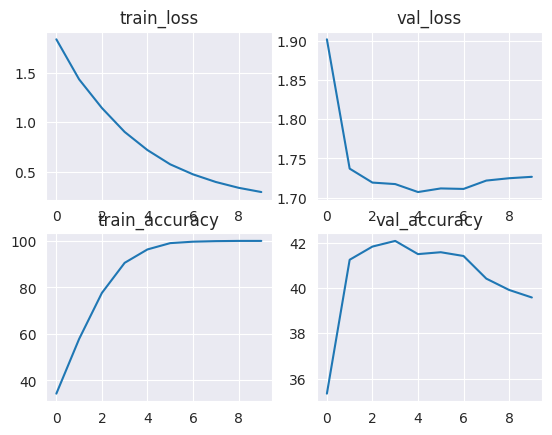

In [109]:
ff_simple_model = FeedForwardSimpleModel(376 * 39, NUM_CLASSES).to(DEVICE)
train_progress, val_progress = executor(DEVICE, ff_simple_model, train_dataloader = train_data_loader, val_dataloader=val_data_loader, epochs=100, learning_rate=0.0001, weight_decay=0.0001, evaluate_per_iteration=10, early_stop_after=(5,  0.001))

plot_metrics(train_progress, val_progress, metrics = ['loss', 'accuracy'])

              precision    recall  f1-score   support

           2       0.29      0.40      0.34        97
          10       0.26      0.20      0.23        94
          12       0.55      0.60      0.58        95
          15       0.40      0.35      0.37        98
          17       0.45      0.52      0.48        94
          21       0.46      0.37      0.41        97
          38       0.32      0.28      0.30        98
        1235       0.36      0.38      0.37        95

    accuracy                           0.39       768
   macro avg       0.39      0.39      0.38       768
weighted avg       0.39      0.39      0.38       768



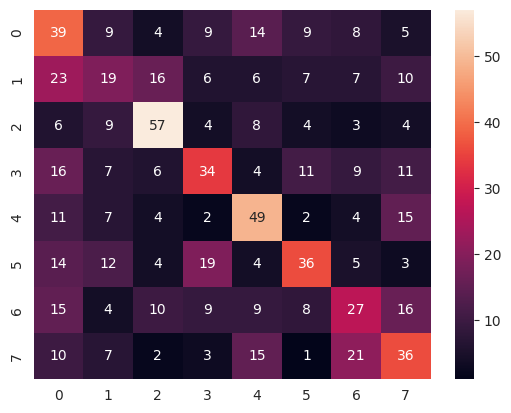

In [110]:
test_loss, test_accuracy, (test_pred, test_true) = evaluate(DEVICE, ff_simple_model, test_data_loader, criterion=nn.CrossEntropyLoss(), return_pred=True)

confusion_matrix_df = pd.DataFrame(confusion_matrix(test_true.cpu(), test_pred.cpu())).rename(columns=idx_to_label, index=idx_to_label)
sns.heatmap(confusion_matrix(test_true.cpu(), test_pred.cpu()), annot=True)

print(classification_report(y_true=list(map(transform_idx_to_label, test_true.cpu().tolist())), y_pred=list(map(transform_idx_to_label, test_pred.cpu().tolist()))))

In [115]:
# Свертка по времени
class Conv1Model(nn.Module):
    def __init__(self, num_class):
        super(Conv1Model, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(94, 1))
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(94, 1))
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(94, 1))
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(94, 1))

        self.linear_1 = nn.Linear(19968, 512)
        self.linear_2 = nn.Linear(512, 256)
        self.linear_3 = nn.Linear(256, 128)
        self.linear_4 = nn.Linear(128, 64)

        self.linear_out = nn.Linear(64, num_class)

        self.relu = nn.ReLU()

        self.conv_batchnorm1 = nn.BatchNorm2d(16)
        self.conv_batchnorm2 = nn.BatchNorm2d(32)
        self.conv_batchnorm3 = nn.BatchNorm2d(64)
        self.conv_batchnorm4 = nn.BatchNorm2d(128)

        self.linear_batchnorm1 = nn.BatchNorm1d(512)
        self.linear_batchnorm2 = nn.BatchNorm1d(256)
        self.linear_batchnorm3 = nn.BatchNorm1d(128)
        self.linear_batchnorm4 = nn.BatchNorm1d(64)


        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.1)
        self.dropout3 = nn.Dropout(0.1)
        self.dropout4 = nn.Dropout(0.1)

    def forward(self, x):
        x = x[:, None,:,:]

        x = self.conv1(x)
        x = self.conv_batchnorm1(x)
        x = self.relu(x)


        x = self.conv2(x)
        x = self.conv_batchnorm2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.conv_batchnorm3(x)
        x = self.relu(x)

        x = self.conv4(x)
        x = self.conv_batchnorm4(x)
        x = self.relu(x)

        x = x.flatten(start_dim = 1)

        x = self.linear_1(x)
        x = self.linear_batchnorm1(x)
        x = self.relu(x)
        #x = self.dropout1(x)

        x = self.linear_2(x)
        x = self.linear_batchnorm2(x)
        x = self.relu(x)
        #x = self.dropout2(x)

        x = self.linear_3(x)
        x = self.linear_batchnorm3(x)
        x = self.relu(x)
        #x = self.dropout3(x)

        x = self.linear_4(x)
        x = self.linear_batchnorm4(x)
        x = self.relu(x)
        #x = self.dropout4(x)

        return self.linear_out(x)

 10%|█         | 10/100 [01:20<12:04,  8.05s/it]

Early stop!


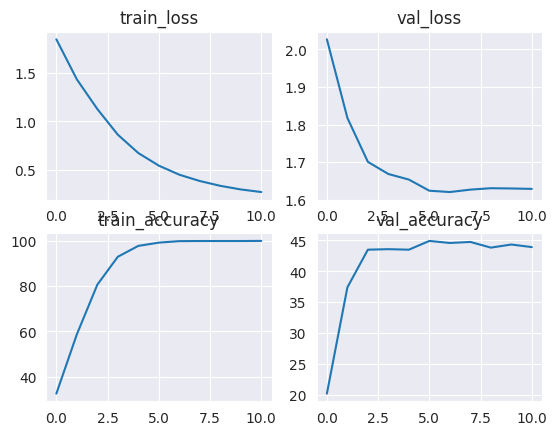

In [116]:
conv_1_model = Conv1Model(NUM_CLASSES).to(DEVICE)
train_progress, val_progress = executor(DEVICE, conv_1_model, train_dataloader = train_data_loader, val_dataloader=val_data_loader, epochs=100, learning_rate=0.0001, weight_decay=0.01, evaluate_per_iteration=10, early_stop_after=(5,  0.01))

plot_metrics(train_progress, val_progress, metrics = ['loss', 'accuracy'])

In [117]:
print(sum(p.numel() for p in conv_1_model.parameters() if p.requires_grad))

11411960


              precision    recall  f1-score   support

           2       0.55      0.50      0.52       100
          10       0.22      0.22      0.22        95
          12       0.50      0.65      0.57        94
          15       0.49      0.38      0.42        96
          17       0.44      0.56      0.49        95
          21       0.57      0.55      0.56        95
          38       0.39      0.35      0.37        98
        1235       0.50      0.45      0.48        95

    accuracy                           0.46       768
   macro avg       0.46      0.46      0.45       768
weighted avg       0.46      0.46      0.45       768



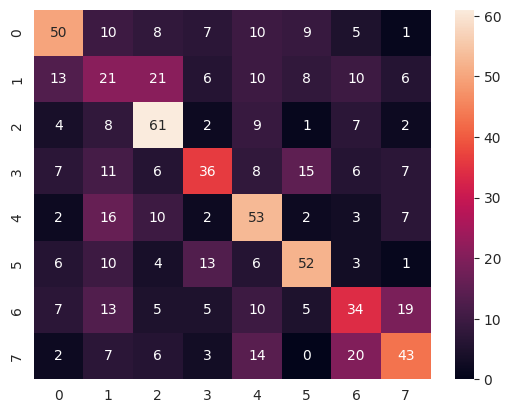

In [118]:
test_loss, test_accuracy, (test_pred, test_true) = evaluate(DEVICE, conv_1_model, test_data_loader, criterion=nn.CrossEntropyLoss(), return_pred=True)

confusion_matrix_df = pd.DataFrame(confusion_matrix(test_true.cpu(), test_pred.cpu())).rename(columns=idx_to_label, index=idx_to_label)
sns.heatmap(confusion_matrix(test_true.cpu(), test_pred.cpu()), annot=True)

print(classification_report(y_true=list(map(transform_idx_to_label, test_true.cpu().tolist())), y_pred=list(map(transform_idx_to_label, test_pred.cpu().tolist()))))

In [121]:
# Свертка по фичам
class Conv2Model(nn.Module):
    def __init__(self, num_class):
        super(Conv2Model, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(1, 6))
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(1, 6))
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1, 6))
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(1, 6))

        self.linear_1 = nn.Linear(914432, 512)
        self.linear_2 = nn.Linear(512, 256)
        self.linear_3 = nn.Linear(256, 128)
        self.linear_4 = nn.Linear(128, 64)

        self.linear_out = nn.Linear(64, num_class)

        self.relu = nn.ReLU()

        self.conv_batchnorm1 = nn.BatchNorm2d(16)
        self.conv_batchnorm2 = nn.BatchNorm2d(32)
        self.conv_batchnorm3 = nn.BatchNorm2d(64)
        self.conv_batchnorm4 = nn.BatchNorm2d(128)

        self.linear_batchnorm1 = nn.BatchNorm1d(512)
        self.linear_batchnorm2 = nn.BatchNorm1d(256)
        self.linear_batchnorm3 = nn.BatchNorm1d(128)
        self.linear_batchnorm4 = nn.BatchNorm1d(64)


        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.1)
        self.dropout3 = nn.Dropout(0.1)
        self.dropout4 = nn.Dropout(0.1)

    def forward(self, x):
        x = x[:, None,:,:]

        x = self.conv1(x)
        x = self.conv_batchnorm1(x)
        x = self.relu(x)


        x = self.conv2(x)
        x = self.conv_batchnorm2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.conv_batchnorm3(x)
        x = self.relu(x)

        x = self.conv4(x)
        x = self.conv_batchnorm4(x)
        x = self.relu(x)

        x = x.flatten(start_dim = 1)

        x = self.linear_1(x)
        x = self.linear_batchnorm1(x)
        x = self.relu(x)
        x = self.dropout1(x)

        x = self.linear_2(x)
        x = self.linear_batchnorm2(x)
        x = self.relu(x)
        x = self.dropout2(x)

        x = self.linear_3(x)
        x = self.linear_batchnorm3(x)
        x = self.relu(x)
        x = self.dropout3(x)

        x = self.linear_4(x)
        x = self.linear_batchnorm4(x)
        x = self.relu(x)
        x = self.dropout4(x)

        return self.linear_out(x)

 15%|█▌        | 15/100 [01:23<07:52,  5.56s/it]

Early stop!


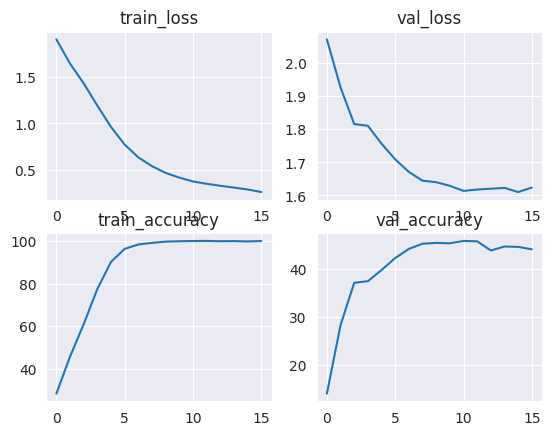

In [122]:
conv_2_model = Conv2Model(NUM_CLASSES).to(DEVICE)
train_progress, val_progress = executor(DEVICE, conv_2_model, train_dataloader = train_data_loader, val_dataloader=val_data_loader, epochs=100, learning_rate=0.0001, weight_decay=0.01, evaluate_per_iteration=10, early_stop_after=(5,  0.01))

plot_metrics(train_progress, val_progress, metrics = ['loss', 'accuracy'])

              precision    recall  f1-score   support

           2       0.45      0.35      0.39        97
          10       0.22      0.23      0.22        96
          12       0.49      0.68      0.57        98
          15       0.42      0.35      0.38        97
          17       0.43      0.54      0.48        93
          21       0.64      0.39      0.48        96
          38       0.27      0.27      0.27        95
        1235       0.37      0.40      0.38        96

    accuracy                           0.40       768
   macro avg       0.41      0.40      0.40       768
weighted avg       0.41      0.40      0.40       768



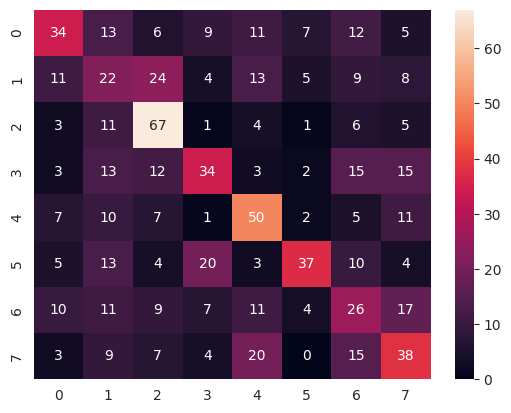

In [123]:
test_loss, test_accuracy, (test_pred, test_true) = evaluate(DEVICE, conv_2_model, test_data_loader, criterion=nn.CrossEntropyLoss(), return_pred=True)

confusion_matrix_df = pd.DataFrame(confusion_matrix(test_true.cpu(), test_pred.cpu())).rename(columns=idx_to_label, index=idx_to_label)
sns.heatmap(confusion_matrix(test_true.cpu(), test_pred.cpu()), annot=True)

print(classification_report(y_true=list(map(transform_idx_to_label, test_true.cpu().tolist())), y_pred=list(map(transform_idx_to_label, test_pred.cpu().tolist()))))

In [124]:
class LSTMSimpleModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_class):
        super(LSTMSimpleModel, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        self.linear_1 = nn.Linear(hidden_dim, 512)
        self.linear_2 = nn.Linear(512, 256)
        self.linear_3 = nn.Linear(256, 128)
        self.linear_4 = nn.Linear(128, 64)

        self.linear_out = nn.Linear(64, num_class)

        self.relu = nn.ReLU()

        self.linear_batchnorm1 = nn.BatchNorm1d(512)
        self.linear_batchnorm2 = nn.BatchNorm1d(256)
        self.linear_batchnorm3 = nn.BatchNorm1d(128)
        self.linear_batchnorm4 = nn.BatchNorm1d(64)


        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.1)
        self.dropout3 = nn.Dropout(0.1)
        self.dropout4 = nn.Dropout(0.1)

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1]
        x = self.tanh(out)

        x = self.linear_1(x)
        x = self.linear_batchnorm1(x)
        x = self.relu(x)
        #x = self.dropout1(x)

        x = self.linear_2(x)
        x = self.linear_batchnorm2(x)
        x = self.relu(x)
        #x = self.dropout2(x)

        x = self.linear_3(x)
        x = self.linear_batchnorm3(x)
        x = self.relu(x)
        #x = self.dropout3(x)

        x = self.linear_4(x)
        x = self.linear_batchnorm4(x)
        x = self.relu(x)

        return self.linear_out(x)

 13%|█▎        | 13/100 [00:48<05:25,  3.74s/it]

Early stop!


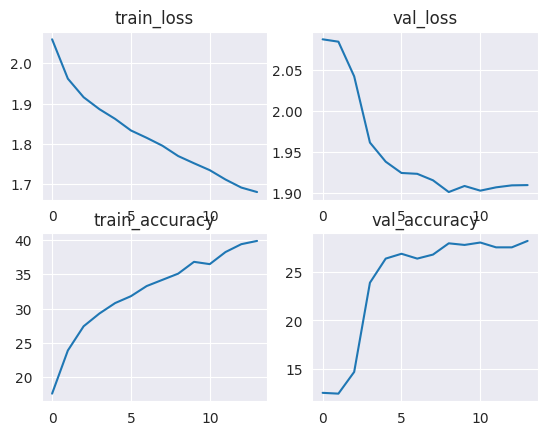

In [127]:
lstm_simple_model = LSTMSimpleModel(39, 1024, NUM_CLASSES).to(DEVICE)
train_progress, val_progress = executor(DEVICE, lstm_simple_model, train_dataloader = train_data_loader, val_dataloader=val_data_loader, epochs=100, learning_rate=1e-4, weight_decay=0.01, evaluate_per_iteration=10, early_stop_after=(5,  0.001))

plot_metrics(train_progress, val_progress, metrics = ['loss', 'accuracy'])

              precision    recall  f1-score   support

           2       0.28      0.22      0.25        95
          10       0.18      0.09      0.12        98
          12       0.32      0.52      0.39        89
          15       0.25      0.32      0.28        98
          17       0.22      0.23      0.22        99
          21       0.18      0.18      0.18        97
          38       0.23      0.16      0.19        97
        1235       0.24      0.27      0.26        95

    accuracy                           0.25       768
   macro avg       0.24      0.25      0.24       768
weighted avg       0.24      0.25      0.24       768



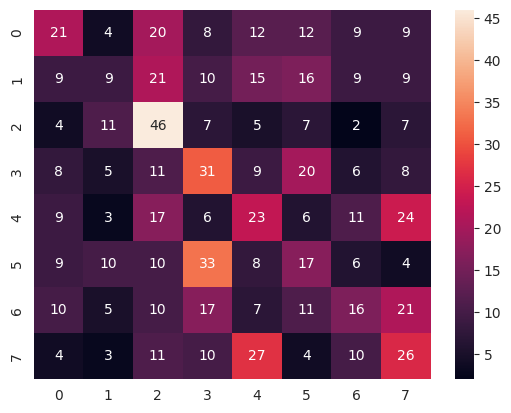

In [128]:
test_loss, test_accuracy, (test_pred, test_true) = evaluate(DEVICE, lstm_simple_model, test_data_loader, criterion=nn.CrossEntropyLoss(), return_pred=True)

confusion_matrix_df = pd.DataFrame(confusion_matrix(test_true.cpu(), test_pred.cpu())).rename(columns=idx_to_label, index=idx_to_label)
sns.heatmap(confusion_matrix(test_true.cpu(), test_pred.cpu()), annot=True)

print(classification_report(y_true=list(map(transform_idx_to_label, test_true.cpu().tolist())), y_pred=list(map(transform_idx_to_label, test_pred.cpu().tolist()))))

In [ ]:
# Свертка по времени
class Conv1Model(nn.Module):
    def __init__(self, num_class):
        super(Conv1Model, self).__init__()



        self.linear_1 = nn.Linear(12288, 512)
        self.linear_2 = nn.Linear(512, 256)
        self.linear_3 = nn.Linear(256, 128)
        self.linear_4 = nn.Linear(128, 64)

        self.linear_out = nn.Linear(64, num_class)

        self.relu = nn.ReLU()



        self.linear_batchnorm1 = nn.BatchNorm1d(512)
        self.linear_batchnorm2 = nn.BatchNorm1d(256)
        self.linear_batchnorm3 = nn.BatchNorm1d(128)
        self.linear_batchnorm4 = nn.BatchNorm1d(64)


        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.1)
        self.dropout3 = nn.Dropout(0.1)
        self.dropout4 = nn.Dropout(0.1)

    def forward(self, x):
        x = x[:, None,:,:]

        x = self.conv1(x)
        x = self.conv_batchnorm1(x)
        x = self.relu(x)


        x = self.conv2(x)
        x = self.conv_batchnorm2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.conv_batchnorm3(x)
        x = self.relu(x)

        x = self.conv4(x)
        x = self.conv_batchnorm4(x)
        x = self.relu(x)

        x = x.flatten(start_dim = 1)

        x = self.linear_1(x)
        x = self.linear_batchnorm1(x)
        x = self.relu(x)
        #x = self.dropout1(x)

        x = self.linear_2(x)
        x = self.linear_batchnorm2(x)
        x = self.relu(x)
        #x = self.dropout2(x)

        x = self.linear_3(x)
        x = self.linear_batchnorm3(x)
        x = self.relu(x)
        #x = self.dropout3(x)

        x = self.linear_4(x)
        x = self.linear_batchnorm4(x)
        x = self.relu(x)
        #x = self.dropout4(x)

        return self.linear_out(x)

In [94]:
class CRNNSimpleModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_class):
        super(CRNNSimpleModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(94, 1))
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(94, 1))
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(94, 1))
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(94, 1))

        self.conv_batchnorm1 = nn.BatchNorm2d(16)
        self.conv_batchnorm2 = nn.BatchNorm2d(32)
        self.conv_batchnorm3 = nn.BatchNorm2d(64)
        self.conv_batchnorm4 = nn.BatchNorm2d(128)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)

        self.linear_1 = nn.Linear(hidden_dim, 512)
        self.linear_2 = nn.Linear(512, 256)
        self.linear_3 = nn.Linear(256, 128)
        self.linear_4 = nn.Linear(128, 64)

        self.linear_out = nn.Linear(64, num_class)

        self.relu = nn.ReLU()

        self.linear_batchnorm1 = nn.BatchNorm1d(512)
        self.linear_batchnorm2 = nn.BatchNorm1d(256)
        self.linear_batchnorm3 = nn.BatchNorm1d(128)
        self.linear_batchnorm4 = nn.BatchNorm1d(64)

        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.1)
        self.dropout3 = nn.Dropout(0.1)
        self.dropout4 = nn.Dropout(0.1)

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = x[:, None,:,:]

        x = self.conv1(x)
        x = self.conv_batchnorm1(x)
        x = self.relu(x)


        x = self.conv2(x)
        x = self.conv_batchnorm2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.conv_batchnorm3(x)
        x = self.relu(x)

        x = self.conv4(x)
        x = self.conv_batchnorm4(x)
        x = self.relu(x)

        print(x.shape)

        out, _ = self.lstm(x)
        out = out[:, -1]
        x = self.tanh(out)

        x = self.linear_1(x)
        x = self.linear_batchnorm1(x)
        x = self.relu(x)
        #x = self.dropout1(x)

        x = self.linear_2(x)
        x = self.linear_batchnorm2(x)
        x = self.relu(x)
        #x = self.dropout2(x)

        x = self.linear_3(x)
        x = self.linear_batchnorm3(x)
        x = self.relu(x)
        #x = self.dropout3(x)

        x = self.linear_4(x)
        x = self.linear_batchnorm4(x)
        x = self.relu(x)

        return self.linear_out(x)

In [95]:
crnn_simple_model = CRNNSimpleModel(24, 512, NUM_CLASSES).to(DEVICE)
train_progress, val_progress = executor(DEVICE, crnn_simple_model, train_dataloader = train_data_loader, val_dataloader=val_data_loader, epochs=100, learning_rate=1e-4, weight_decay=0.01, evaluate_per_iteration=10, early_stop_after=(5,  0.001))

plot_metrics(train_progress, val_progress, metrics = ['loss', 'accuracy'])

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([256, 128, 4, 24])


RuntimeError: input must have 3 dimensions, got 5